# TP - ES Problèmes inverses

Vincent Duval, Nicolas Desassis (à partir du TP en Matlab de Michel Kern)

## Exercice 2 - Régularisation et choix du paramètre

Nous allons illustrer l’utilisation les concepts théoriques vus en cours sur un exemple
simple. Nous allons pour cela utiliser un petit sous ensemble de la boîte à outils « Regularization Toolbox » écrite par  [P. C. Hansen](http://www2.imm.dtu.dk/~pcha/Regutools/). Initialement écrites en Matlab les fonctions de cette "Toolbox" utiles à ce TP ont été traduites en Julia (dans des versions minimalistes).


In [ ]:
# Import de la Toolbox
include("toolBox.jl");

On choisit pour la suite le problème test « gravity » qui simule un problème de prospection gravimétrique. Il s'agit d'estimer une densité de matière dans le sous-sol à partir du champ de pesanteur mesuré en surface.

Voir en particulier la [page Wikipédia](https://fr.wikipedia.org/wiki/Gravim%C3%A9trie#G%C3%A9ophysique) dont voici un extrait

> Les applications [de la gravimétrie] sont très diverses, notamment pour caractériser un aquifère, une cavité, un glacier, un dôme de sel, un site archéologique, un gîte métallifère, un bassin sédimentaire ou la structure d'une chaîne de montagne. La gravimétrie aéroportée permet d’étudier d’importantes étendues en peu de temps, mais avec une précision moindre qu'en gravimétrie terrestre : cette technique donne des résultats applicables à l’exploration pétrolière et minière. Elle permet également d'évaluer l'épaisseur des calottes polaires et aider ainsi à l'estimation du réchauffement climatique. Elle a permis de découvrir des cratères d'impacts anciens rendus invisibles à cause de l'érosion, comme le cratère de Morokweng en Afrique du Sud.





Un observateur à la surface du sol veut évaluer la densité de matière à la profondeur $d$. 
La densité de matière $u(s)$ à l'abscisse $s$ et à la profondeur $d$ contribue au champ de gravité au point de la surface d'abscisse $t$ proportionnellement à $-\frac{1}{r_{st}^2}u(s)\vec{e}_{st}\mathrm{d}s$ où $r_{st}=\sqrt{d^2+(s-t)^2}$ est la distance entre le point du sous-sol d'abscisse $s$ et celui de la surface d'abscisse $t$, et $\vec{e}_{st}$ un vecteur unitaire qui dirige la droite passant par ces deux points. On ne mesure que la composante verticale de ce vecteur. 

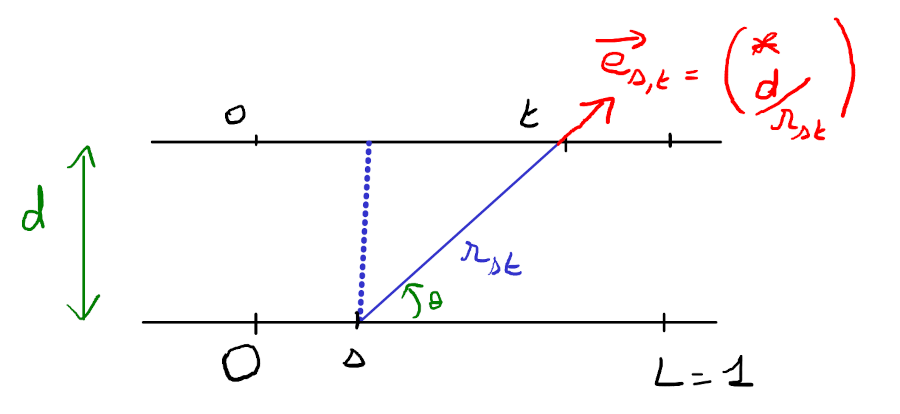

Sachant que la composante verticale de $\vec{e}_{st}$ vaut  $\frac{d}{r_{st}}$, on est donc amené à étudier l’équation intégrale:

$$\int_0^1\frac{d}{(d^2+(s-t)^2)^{3/2}}u(s)\mathrm{d}s = f(t)\hspace{3mm} t\in[0,1]$$

où (à une constante multiplicative près) $f(t)$ est la composante verticale du champ de pesanteur mesurée au point d'abscisse $t$.

On discrétisera cette expression par une formule de quadrature à n points. On prendra comme densité solution le choix
par défaut $u(s)= \sin(\pi s) + 0.5 * \sin(2\pi s).$

Le caractère mal posé du problème (la vitesse de décroissance des valeurs singulières)
dépend du paramètre $d$ (qui représente la profondeur). Dans tout l’exercice, vous comparerez le comportement des différentes méthodes pour $d = 0.1$ (problème modérément mal
posé), et pour $d = 0.25$ (problème sévèrement mal posé).

**1**. Écrire la matrice et le second membre du système $Ax=b$. La commande Julia correspondante est (on pourra prendre `n = 80`) : 

```A,bex,xex = gravity(n, 1, 0, 1, d);```

Essayer de résoudre le système linéaire par la méthode usuelle (`xnaif = A \bex`). 

Commenter la solution obtenue.

In [ ]:
n=80
d1=0.1
A1,bex1,xex = gravity(n, 1, 0, 1, d1);
xnaif1= A1\bex1;
plot(xex,label="xex (vérité terrain)")
display(plot!(xnaif1,label="xnaif"))

In [ ]:
d2=0.25
A2,bex2,xex = gravity(n, 1, 0, 1, d2);
xnaif2= A2\bex2;
#Test d'autres résolutions
#SVD :
#U,S,V=svd(A2);
#xnaif2 = V * ((1 ./S) .* (U'*bex2));
#QR :

#Q,R = qr(A2);
#xnaif2 = R\(Q'*bex2)[1:size(A2,2)];

print(sum((A2*xnaif2-bex2)))
plot(xex,label="xex (vérité terrain)")
display(plot!(xnaif2,label="xnaif"))

**2**. Calculer la décomposition en valeurs singulières de A, en utilisant la commande
`U, s, V = svd(A)`, puis visualiser la décroissance des valeurs singulières (commande
`picard`). On pourra aussi visualiser quelques vecteurs singuliers. Que constate-t-on ?

In [ ]:
U1, S1, V1= svd(A1);
picard(U1,S1,bex1);

In [ ]:
U2, S2, V2= svd(A2);
picard(U2,S2,bex2);

On ajoute maintenant un bruit aléatoire Gaussien d'écart-type $\nu$ au second membre (on
prendra par exemple $\nu = 10^{−1}$ ). La commande correspondante est (perturbation relative) :

`e = nu * randn(size(bex)); b = bex .* (1. .+ e);`

Reprendre la question précédente.

In [ ]:
nu=1e-1
e = nu * randn(size(bex1));
bb1 = bex1 .* (1 .+ e);
xnaif1= A1\bb1;
plot(xex,label="xex (vérité terrain)")
display(plot!(xnaif1,label="xnaif"))

In [ ]:
bb2 = bex2 .* (1 .+ e);
xnaif2= A2\bb2;
plot(xex,label="xex (vérité terrain)")
display(plot!(xnaif2,label="xnaif"))

**3**.
Prendre une dizaine de valeurs du paramètre de régularisation ε, et calculer la solution
régularisée  par le problème 
$$ \min_x \frac{\varepsilon^2}{2}\|x\|^2 +\frac{1}{2}\|Ax-b\|^2$$
correspondante. On utlisera la commande `tikhonov`. Noter que pour cette commande, le paramètre de régularisation peut-être un vecteur, ce qui permet de traiter tous les paramètres
d’un seul coup.

Faire de même pour la méthode de troncature spectrale (commande `tsvd`), en variant
le nombre de valeurs singulières retenues.

In [ ]:
epsvec=[10,5,3,2, 1]# ,1e-1] # A COMPLETER ET MODIFIER

x_lambda,rho,eta = tikhonov(U1,S1,V1,bb1,epsvec,zeros(size(xex)))

a=plot(xex,label="xex (vérité terrain)")
for k in 1:size(epsvec,1)
    plot!(x_lambda[:,k],labels="Tikhonov "*string(epsvec[k]))
end
display(a)

In [ ]:
epsvec=[10,5,3,2, 1] # A COMPLETER ET MODIFIER

x_lambda,rho,eta = tikhonov(U2,S2,V2,bb2,epsvec,zeros(size(xex)))

a=plot(xex,label="xex (vérité terrain)")
for k in 1:size(epsvec,1)
    plot!(x_lambda[:,k],labels="Tikhonov "*string(epsvec[k]))
end
display(a)


In [ ]:
K=[3,4,6,8]
x_k,rho,eta = tsvd(U1,S1,V1,bb1,K)

a=plot(xex,label="xex (vérité terrain)")
for k in 1:size(K,1)
    plot!(x_k[:,k],labels="TSVD k="*string(K[k]))
end
display(a)



In [ ]:
x_k,rho,eta = tsvd(U2,S2,V2,bex2,K)

a=plot(xex,label="xex (vérité terrain)")
for k in 1:size(K,1)
    plot!(x_k[:,k],labels="TSVD k="*string(K[k]))
end
display(a)

**4**.
Évaluer, pour ce problème, diverses méthodes du choix du paramètre de régularisation
(commandes l_curve, discrep ou gcv).


Pour le principe de l’écart, on prendra comme estimation de la norme du bruit $\sqrt{n}η$ avec
$η = 10^{−2}$ (pour l’exemple ci-dessus), puis essayer avec une valeur supérieure ou inférieure
de 5\%. Évaluer la sensibilité de la solution à ces changements.
Pour la courbe en L, ou la GCV, générer plusieurs perturbations différentes, et tracer
les courbes correspondantes. Le minimum des fonctions se trouve-t-il toujours au même
endroit (« coin » de la courbe en L, région de transition pour GCV)?


### Courbe en L

In [ ]:
l_curve(U1,S1,bb1,"Tikh");
l_curve(U2,S2,bb2,"Tikh");
l_curve(U1,S1,bb1,"tsvd");
l_curve(U2,S2,bb2,"tsvd");

**Remarque:** Observez que la fonction l_curve n'a besoin que de $U$ (les vecteurs singuliers à gauche) et $S$ (les valeurs singulières), et non pas de $A$ tout entière. Savez-vous pourquoi?"

### Principe de Morozov (discrepancy)

In [ ]:
K=[3,4,6,8]
x_k,rho,eta = tsvd(U1,S1,V1,bb1,K)
deltaref=sqrt(n)*eta # norme typique du bruit
#deltavec=[0.95*deltaref ;deltaref; 1.05*deltaref][:] # vecteur de discrepancy
deltavec=[0.84971   0.89443   0.93915][:]
x_delta,lambda = discrep(U1,S1,V1,bb1,deltavec,zeros(size(xex)))
lambda

In [ ]:
x_k,rho,eta = tsvd(U2,S2,V2,bb2,K)
deltaref=sqrt(n)*eta # norme typique du bruit
deltavec=[0.95*deltaref ;deltaref; 1.05*deltaref][:] # vecteur de discrepancy
deltavec=[0.84971   0.89443   0.93915][:]
x_delta,lambda = discrep(U2,S2,V2,bb2,deltavec,zeros(size(xex)))
lambda

### GCV

In [ ]:
reg_min1ti,reg_param ,G=gcv(U1,S1,bb1,"Tikh");
reg_min2ti,reg_param ,G=gcv(U2,S2,bb2,"Tikh");
reg_min1ts,reg_param ,G=gcv(U1,S1,bb1,"tsvd");
reg_min2ts,reg_param ,G=gcv(U2,S2,bb2,"tsvd");

**5.**
(Facultatif) Reprendre l’ensemble des questions dans le cas où la solution exacte est
une fonction constante par morceaux (changer le paramètre example en example=2 dans
l’appel de `gravity`).